In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.111:57765 Dashboard: http://10.148.0.111:8787/status,Cluster Workers: 60 Cores: 240 Memory: 3000.00 GB


---


# 1. Data files
#### important faces: 1, 2, 4, 5, 7, 8, 10, 11
#### other faces (polar regions): 0, 3, 6, 9, 12

In [5]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/'

print(data_dir)
print(E_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC1080/
/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/


## Grid

### LLC1080

In [6]:
# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


_______
# 2. Rotary spectra of horizontal velocity

________
## Method 2: An update on xrft

### The latest xrft supports 'time_to_segments', i.e. takes chunks along the dimension of FFT, and divides into segments (length of chunks) automatically, but it might be tricky to do overlapping.

In [7]:
face_all = [1, 2, 4, 5, 7, 8, 10, 11]

In [10]:
## Here we do DFT on u+iv ##
time_chunk = 1440
ij_chunk = 108

for face in face_all:
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
    ds_SSU = ds_SSU.chunk(chunks) 
    # Read SSV #
    ds_SSV = xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
    ds_SSV = ds_SSV.chunk(chunks) 
    # Merge into one xarray dataset #
    ds = xr.merge([ds_SSU, ds_SSV, grid])    
    #print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
    
    # u+iv
    uv_complex = (ds_SSU['SSU'] + 1j*ds_SSV['SSV'])
    # fft
    #E_uv_segments = xrft.power_spectrum(uv_complex.fillna(0.), dim=['time'], window=True, detrend='constant',chunks_to_segments=True)
    uv_fft_complex = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)    
    E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600        
    E_uv = E_uv_segments.mean(dim=['time_segment']) 
    E_uv = np.real(E_uv).rename('E_uv')
    E_uv = xr.merge([E_uv, grid])
    file_E = E_dir+'E_uv_f%02d_1080.zarr'%face
    %time E_uv.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

CPU times: user 1min 15s, sys: 3.41 s, total: 1min 19s
Wall time: 1min 52s
face 1 done
CPU times: user 1min, sys: 3.17 s, total: 1min 4s
Wall time: 1min 23s
face 2 done
CPU times: user 1min 22s, sys: 3.72 s, total: 1min 26s
Wall time: 2min 1s
face 4 done
CPU times: user 52.3 s, sys: 1.98 s, total: 54.3 s
Wall time: 1min 12s
face 5 done
CPU times: user 1min 22s, sys: 3.48 s, total: 1min 25s
Wall time: 1min 56s
face 7 done
CPU times: user 1min 30s, sys: 4.15 s, total: 1min 34s
Wall time: 2min 15s
face 8 done
CPU times: user 1min 4s, sys: 2.79 s, total: 1min 7s
Wall time: 1min 28s
face 10 done
CPU times: user 1min 22s, sys: 3.39 s, total: 1min 26s
Wall time: 1min 58s
face 11 done


### 2.1 global ocean

In [11]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0

for face in face_all:

    ds = xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face))
    chunks={'i': 108, 'j':108, 'freq_time':360}
    ds = ds.chunk(chunks)     
    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv).fillna(-100.)
    lat2.transpose('freq_time', 'i', 'j')  ####

    f2 = lat2.T*0. + f
    
    dA = ds.rA + 0.*f2
    dA.transpose('freq_time', 'i', 'j') ####

    EdA = ds.E_uv.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.T.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)
    
    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.T.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_zarr(E_dir+'E_rotary_zavg_f%02d_1080.zarr'%face, mode='w')
    print('face %d done'%face )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 2 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 4 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 5 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 7 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 8 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 10 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 11 done


### 2.2 open ocean (deeper than 500 m)

In [9]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0

for face in face_all:

    ds = xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face))
    chunks={'i': 108, 'j':108, 'freq_time':360}
    ds = ds.chunk(chunks)     
    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv.where(ds.Depth>500)).fillna(-100.)
    lat2.transpose('freq_time', 'i', 'j')  ####

    f2 = lat2.T*0. + f
    
    dA = ds.rA + 0.*f2
    dA.transpose('freq_time', 'i', 'j') ####

    EdA = ds.E_uv.where(ds.Depth>500).fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.T.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)
    
    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.T.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%face, mode='w')
    print('face %d done'%face )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 2 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 4 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 5 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 7 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 8 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 10 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


face 11 done


# 3. Figures

In [8]:
#D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
D = [xr.open_zarr(E_dir+'E_rotary_zavg_f%02d_1080.zarr'%(face)) for face in face_all] # global-ocean
ds = xr.concat(D, dim='face')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 8, freq_time: 1439, lat: 120)
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
Dimensions without coordinates: face
Data variables:
    A          (face, lat) float64 dask.array<shape=(8, 120), chunksize=(1, 120)>
    E          (face, lat, freq_time) float64 dask.array<shape=(8, 120, 1439), chunksize=(1, 60, 720)>


In [9]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


### 3.1 lat-freq

### Note: (i) full colorscale [-1, 4] (ii) Shane's colorscale [0.5, 4] (iii) full frequency range [-12 12] cpd

### global ocean

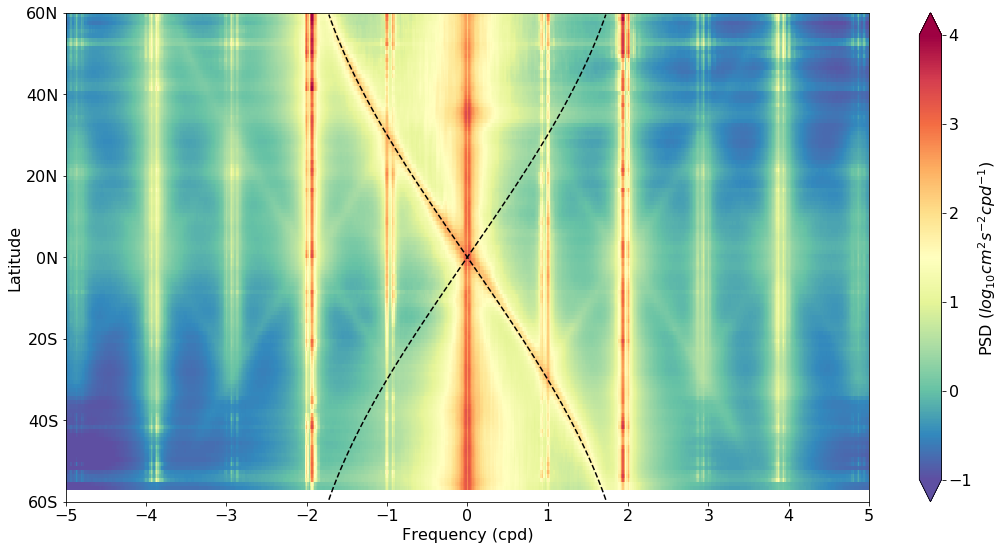

In [10]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

### open ocean

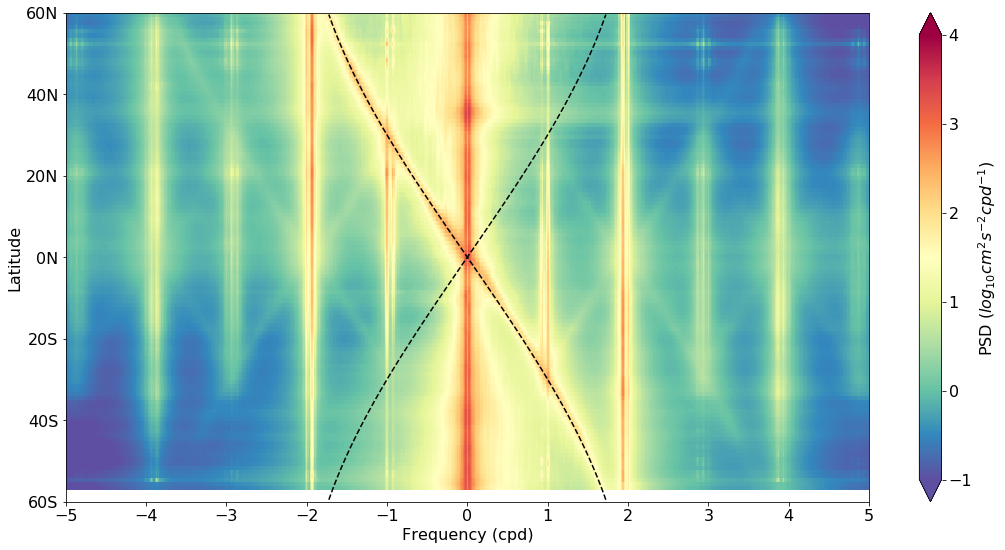

In [12]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

### 3.2 Band-frequency integral

In [13]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [14]:
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


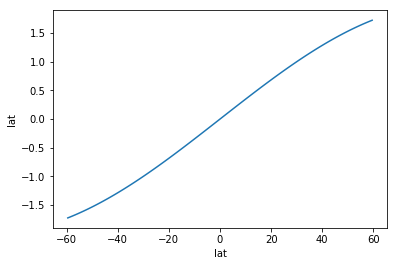

In [15]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

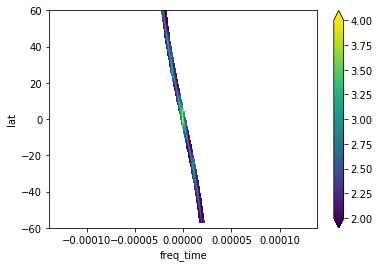

In [16]:
np.log10(E.where(abs(E.freq_cpd+f_cpd)<.2, other=0.)).plot(vmin=2, vmax=4)

## Total energy vs Band-frequency integral

### open ocean

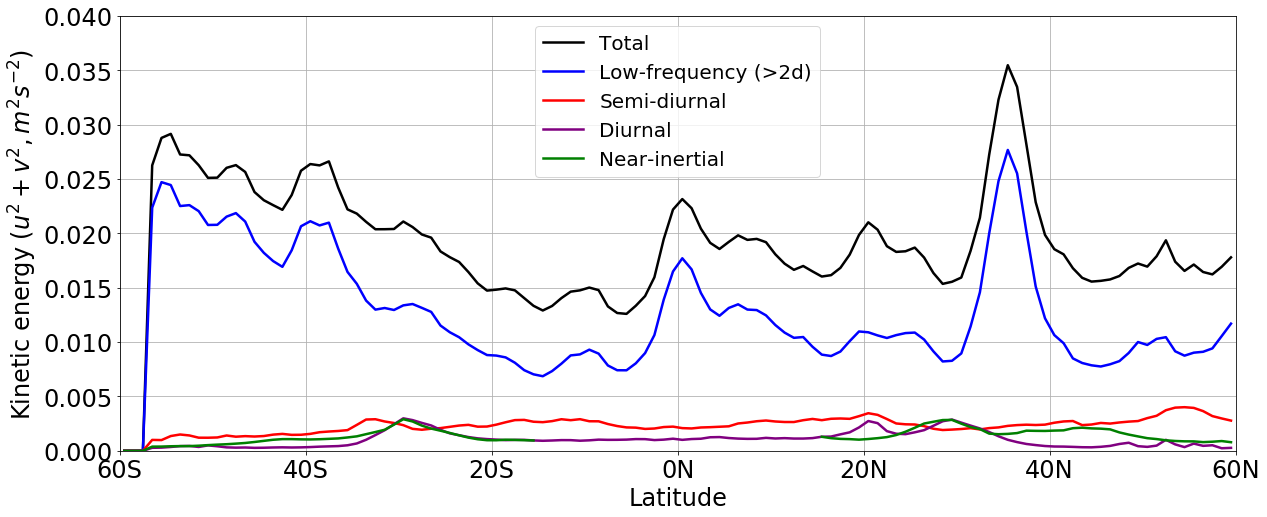

In [18]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.04])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

### global ocean

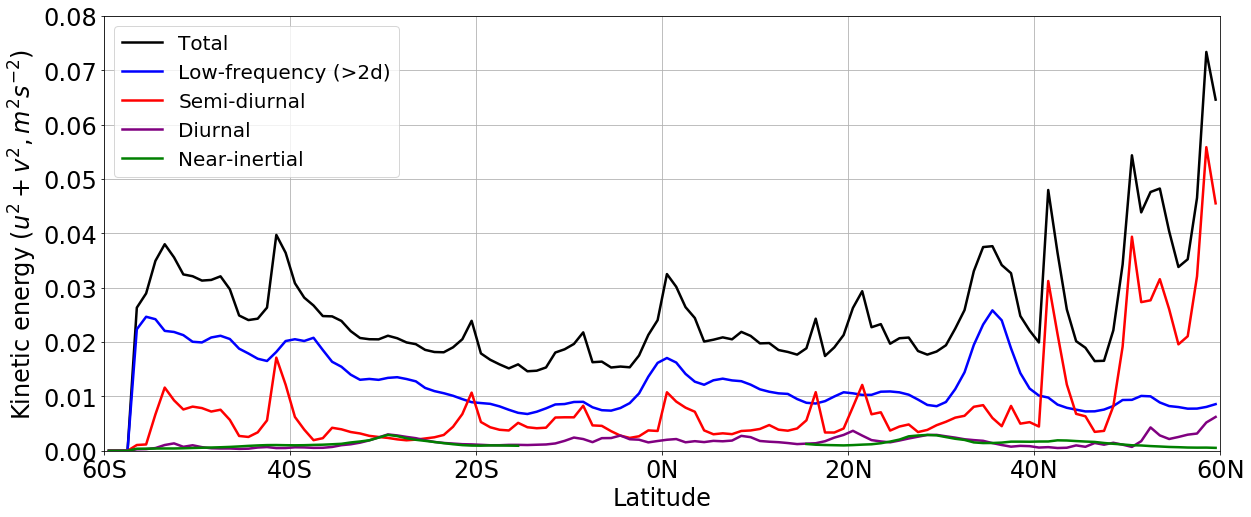

In [19]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.08])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

### 3.3 global-averaged

In [43]:
D = [xr.open_zarr(E_dir+'E_uv_f%02d_1080.zarr'%(face)) for face in face_all]
ds = xr.concat(D, dim='face')

In [49]:
E_uv_north = ((ds.E_uv).where((ds.YC>0.) & (ds.Depth>500.))).mean(dim=('i','j','face'))   
E_uv_north = np.real(E_uv_north).rename('E_uv_north')
file_E = E_dir+'E_uv_north_allmean_openocean.zarr'  
%time E_uv_north.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 16.3 s, sys: 896 ms, total: 17.2 s
Wall time: 28 s


In [50]:
E_uv_south = ((ds.E_uv).where((ds.YC<0.) & (ds.Depth>500.))).mean(dim=('i','j','face'))   
E_uv_south = np.real(E_uv_south).rename('E_uv_south')
file_E = E_dir+'E_uv_south_allmean_openocean.zarr'  
%time E_uv_south.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 16.5 s, sys: 892 ms, total: 17.4 s
Wall time: 28.4 s


In [52]:
ds = xr.open_zarr(E_dir+'E_uv_south_allmean_openocean.zarr')
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_south         (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [53]:
E_south = ds.E_uv_south
E_south = E_south.assign_coords(freq_time=ds.E_uv_south.freq_time * 86400.) 
print(E_south)

<xarray.DataArray 'E_uv_south' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [54]:
E0_south = E_south/8.64

In [55]:
ds0 = xr.open_zarr(E_dir+'E_uv_north_allmean_openocean.zarr')
print(ds0)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_north         (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [56]:
E_north = ds0.E_uv_north
E_north = E_north.assign_coords(freq_time=ds0.E_uv_north.freq_time * 86400.) 
print(E_north)

<xarray.DataArray 'E_uv_north' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [57]:
E0_north = E_north/8.64

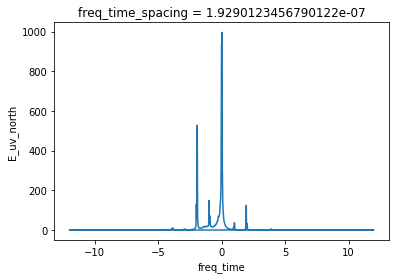

In [58]:
E0_north.plot()

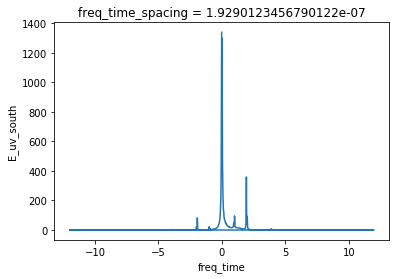

In [59]:
E0_south.plot()

In [60]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


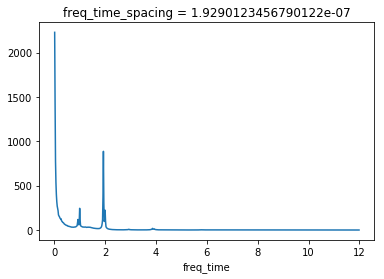

In [61]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [62]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [63]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


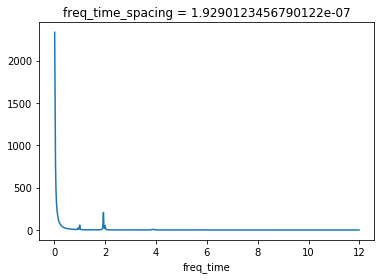

In [64]:
E0_cycl.plot()

In [65]:
E_cycl_all = E0_cycl
E_anti_all = E0_anti

Text(0.5,1,'All the world oceans')

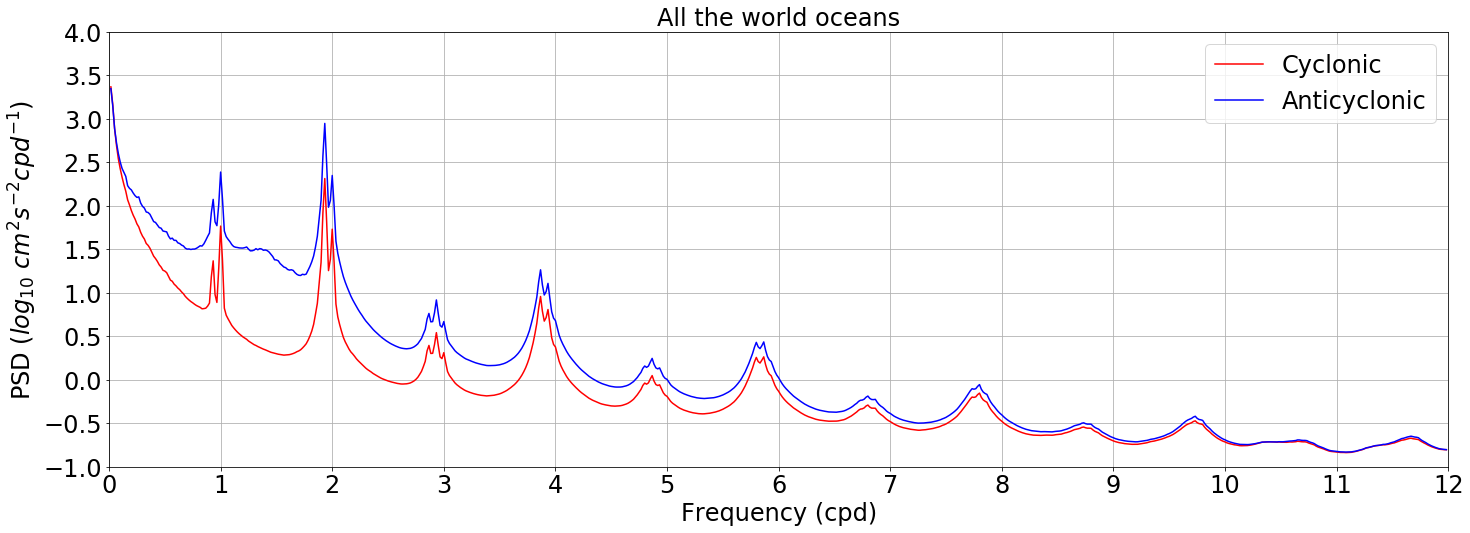

In [66]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('All the world oceans',fontsize=24)


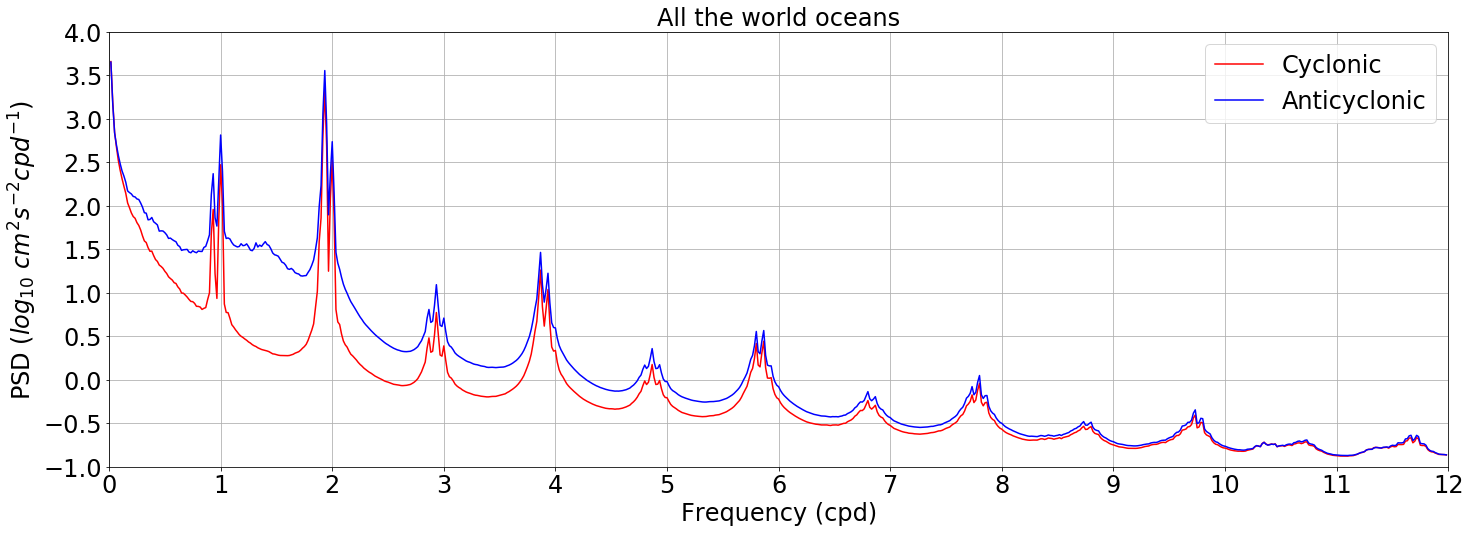

In [20]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('All the world oceans',fontsize=24)





__________
## Method 3:

### Following  Ryan's https://gist.github.com/rabernat/fd2522f1937a43f49ac0423d35915648

#### The big difference is to turn the 4D data (time,face,i,j) into a 2D dataset (time, point).

### Memory limited:

#### 1. (4320,4320) case: works for one face with 30 days chunk, but appears not enough memory for more faces and longer time chunk.

#### 2. (1080,1080) case: works fine.

In [11]:
face_all = [1, 2, 4, 5, 7, 8, 10, 11]

In [12]:
face = face_all

#Grid #
grid = mgrid.isel(face=face)
    
# Read SSU #
D = [xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'}) for face in face_all]
ds_SSU = xr.concat(D, dim='face')
chunks={'time': 1440,'i': 108, 'j': 108} # time chunck: (2 months)
ds_SSU = ds_SSU.chunk(chunks) 

# Read SSV #
D = [xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'}) for face in face_all]
ds_SSV = xr.concat(D, dim='face')
chunks={'time': 1440,'i': 108, 'j': 108} # time chunck: (2 months)
ds_SSV = ds_SSV.chunk(chunks) 

print(ds_SSU)
print('\n data size: %.1f GB' %(ds_SSU.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 8, i: 1080, j: 1080, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * face     (face) int64 1 2 4 5 7 8 10 11
Data variables:
    SSU      (face, time, j, i) float32 dask.array<shape=(8, 8640, 1080, 1080), chunksize=(1, 1440, 108, 108)>

 data size: 322.5 GB


In [13]:
subset_factor = 4

ds_subset = (xr.merge([grid.reset_coords()[['XC', 'YC','CS', 'SN']], ds_SSU, ds_SSV])
               .isel(j=slice(0 ,None, subset_factor),
                     i=slice(0, None, subset_factor))
               .stack(point=['face','j', 'i'])
               .chunk({'time': 1440, 'point': 10000})) # chunk it into 30 day segments (60 days not working - killed workers)
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (point: 583200, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * point    (point) MultiIndex
  - face     (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - i        (point) int64 0 16 32 48 64 80 96 112 128 144 160 176 192 208 ...
Data variables:
    XC       (point) float32 dask.array<shape=(583200,), chunksize=(10000,)>
    YC       (point) float32 dask.array<shape=(583200,), chunksize=(10000,)>
    CS       (point) float32 dask.array<shape=(583200,), chunksize=(10000,)>
    SN       (point) float32 dask.array<shape=(583200,), chunksize=(10000,)>
    SSU      (time, point) float32 dask.array<shape=(8640, 583200), chunksize=(1440, 10000)>
    SSV      (time, point) float32 dask.array<shape=(8640, 583200), chunksize=

In [14]:
Z = ds_subset.SSU + 1j*ds_subset.SSV
print(Z)
print('\n data size: %.1f GB' %(Z.nbytes / 1e9))

<xarray.DataArray (time: 8640, point: 583200)>
dask.array<shape=(8640, 583200), dtype=complex64, chunksize=(1440, 10000)>
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * point    (point) MultiIndex
  - face     (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - i        (point) int64 0 16 32 48 64 80 96 112 128 144 160 176 192 208 ...

 data size: 40.3 GB


In [15]:
Z_ps = xrft.power_spectrum(Z, dim=['time'], window=True, detrend='constant', chunks_to_segments=True)
print(Z_ps)
print('\n data size: %.1f GB' %(Z_ps.nbytes / 1e9))

<xarray.DataArray 'rechunk-merge-dcac8eaa1280c50075d35498c180f97e' (time_segment: 6, freq_time: 1440, point: 583200)>
dask.array<shape=(6, 1440, 583200), dtype=float64, chunksize=(1, 1440, 10000)>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3 4 5
  * freq_time          (freq_time) float64 -0.0001389 -0.0001387 -0.0001385 ...
  * point              (point) object (1, 0, 0) (1, 0, 16) (1, 0, 32) ...
    freq_time_spacing  float64 1.929e-07

 data size: 40.3 GB


In [24]:
Z_fft_complex = xrft.dft(Z.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)    
Z_ps = (Z_fft_complex*Z_fft_complex.conj()).where(Z_fft_complex!=0., drop=False)/1440*3600    

print(Z_ps)
print('\n data size: %.1f GB' %(Z_ps.nbytes / 1e9))

<xarray.DataArray 'fftn-2250d66fdbb1631e6a2558558d8b67ea' (time_segment: 6, freq_time: 1440, point: 2332800)>
dask.array<shape=(6, 1440, 2332800), dtype=complex128, chunksize=(1, 1440, 10000)>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3 4 5
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (1, 0, 0) (1, 0, 8) (1, 0, 16) ...
    freq_time_spacing  float64 1.929e-07

 data size: 322.5 GB


In [16]:
Z_ps_zonmean = (Z_ps.groupby_bins(ds_subset['YC'], np.arange(-61, 62, 2), labels=np.arange(-60, 61, 2))
                    .mean(dim=['time_segment', 'point']))
print(Z_ps_zonmean)

<xarray.DataArray 'rechunk-merge-dcac8eaa1280c50075d35498c180f97e' (freq_time: 1440, YC_bins: 61)>
dask.array<shape=(1440, 61), dtype=float64, chunksize=(1440, 2)>
Coordinates:
  * YC_bins            (YC_bins) int64 -60 -58 -56 -54 -52 -50 -48 -46 -44 ...
  * freq_time          (freq_time) float64 -0.0001389 -0.0001387 -0.0001385 ...
    freq_time_spacing  float64 1.929e-07


In [17]:
print(len(Z_ps_zonmean.data.dask))
%time Z_ps_zonmean_p = Z_ps_zonmean.persist(retries=10)

763851
CPU times: user 1min 5s, sys: 1.32 s, total: 1min 6s
Wall time: 1min 6s


In [18]:
# for one face with 30days segment, memory use over 50%

# 1440*10^6 - 1 min
# 1440*10^7 (10^4 chunks) - 3 min 
# 1440*10^7 (2*10^3 chunks) - 4.5 min

%time Z_ps_zonmean_p = Z_ps_zonmean_p.load()  ## not enough memory for multi-faces

CPU times: user 9min 14s, sys: 26.3 s, total: 9min 41s
Wall time: 10min 37s


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


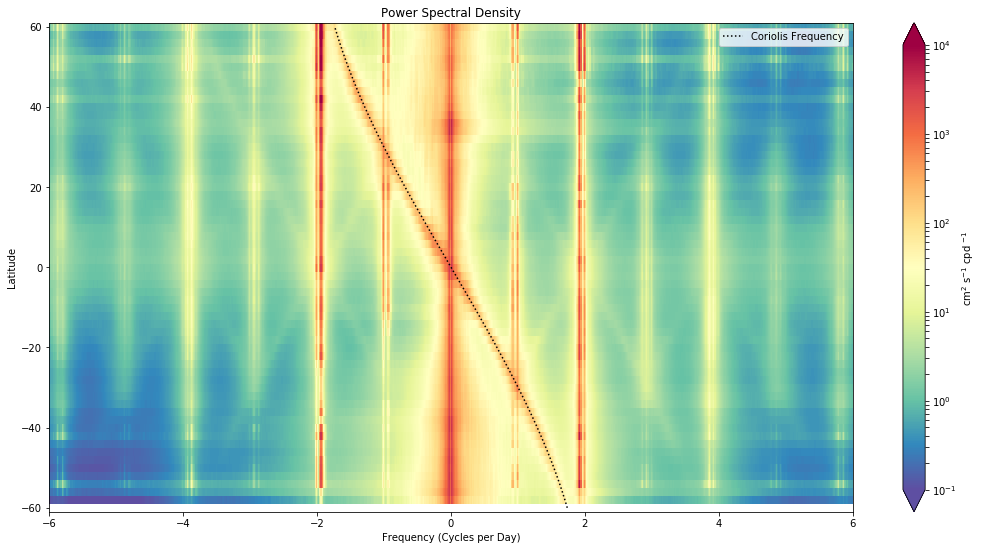

In [20]:
day = 24*60*60
Z_ps_zonmean_p.coords['freq_cycles_per_day'] = Z_ps_zonmean_p.freq_time * day
Z_ps_zonmean_p.coords['freq_cycles_per_day'].attrs['units'] = 'cycles per day'
# original units are m2/s2 / (cycles per s) = m2 s / (cycles s^2)
# want (cm2 / s2) / (cycles per day) = cm2 day / (cycles s^2)
# 100 cm / m
# 24*60*60 days / s
scale_fac =  day / (10000)

ps_to_plot = scale_fac * Z_ps_zonmean_p.swap_dims({'freq_time': 'freq_cycles_per_day'})
ps_to_plot = ps_to_plot.rename(r'cm$^2$ s$^{-1}$ cpd $^{-1}$')

omega = 7.2921e-5
f_coriolis = (2*omega*np.sin(np.deg2rad(ps_to_plot.YC_bins))) * day / (2*np.pi)

from matplotlib.colors import LogNorm
ps_to_plot.transpose().plot(figsize=(18,9), cmap='Spectral_r', norm=LogNorm(), vmin=1e-1, vmax=1e4)
(-f_coriolis).plot.line(y='YC_bins', color='k', linestyle=':')
plt.xlim([-6, 6])
plt.xlabel('Frequency (Cycles per Day)')
plt.ylabel('Latitude')
plt.title('Power Spectral Density')
plt.legend(['Coriolis Frequency'])

In [22]:
cluster.scheduler.close()

<Future finished result=None>